In [91]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import os
import pprint
import re
import seaborn as sns

In [92]:
resultre = re.compile(r'^.+\/(?P<modelname>[^_]+)_(?P<imgsz>[\d]+)imgsz_(?P<traindataset>[^_]+)_(?P<epochs>[^-]+?)epochs_(?P<weights>[^_]+)_(?P<datasetname>.+)_test$')
metricre = re.compile(r'^(?P<category>category)?_*(?P<metric>metrics/)?(?P<name>[^(]*).*?$')
testsetre = re.compile(f'^test-set-(?P<cams>\d+)cameras?-?(?P<camname>[^_]+)?_(?P<datasetformat>[^_]+)$')

def join_mask( mask_list,combineor=False ):
    full_mask = None
    for m in mask_list:
        if full_mask is None:
            full_mask = m
        else:
            if combineor:
                full_mask = full_mask | m
            else:
                full_mask = full_mask & m
    return full_mask

def rename_test_dataset( s, returndict=False ):
    #test-set-1camera-ip8m-h-nw_yolov8
    m = testsetre.match(s)
    if m is None:
        return "Unknown"
    else:
        gd = m.groupdict()
        #pprint.pprint(gd)

        if gd['camname'] is not None:
            camplural = "camera" if int(gd['cams']) == 1 else "cameras"
            if int(gd['cams']) == 1:
                #gd['simplename'] = f"{gd['cams']}{camplural}_{gd['camname'].upper()}"
                gd['simplename'] = f"{gd['camname'].upper()}"
            else:
                gd['simplename'] = f"{gd['cams']}{camplural}_{gd['camname']}"
        else:
            gd['simplename'] = f"{gd['cams']}cameras_all"
        if returndict:
            return gd
        else:
            return gd['simplename']

In [87]:
resultdir = "/data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/test"
#11s_1440imgsz_IP8M-H-SW_150epochs_test-set-1camera-ip8m-h-sw_yolov8_test


model_parent = "yolov"
val_results = []
plot_metrics = ['mAP50-95'] #'Precision', 'Recall', 'mAP50', 'mAP50-95', ]

for testresult in glob.glob(f"{resultdir}/*_test"):
    
    match = resultre.match(testresult)
    if match is None:
        print(F"didn't match directory name {valresult}")
        continue
    params = match.groupdict()
    new_result = params.copy()

    new_result['modelname'] = f"{model_parent}{new_result['modelname']}"
    if new_result['epochs'] == "best":
        new_result['epochs'] = 150
    
    if not os.path.exists(f"{testresult}/metrics.json"):
        print(f"{testresult}/metrics.json doesn't exist right now, skipping")
        continue
   
    with open(f"{testresult}/metrics.json") as r:
        metrics = json.load(r)
        for k, v in metrics.items():
            kmatch = metricre.match(k)
            if kmatch is not None:
                md = kmatch.groupdict()
                if md['metric'] is not None:
                    k = md['name']
                    new_result[ md['name'] ] = v
                elif md['category'] is not None:
                    if len(v) == 0:
                        new_result[ f"{md['category']}_{md['name']}" ] = 0
                    else:
                        new_result[ f"{md['category']}_{md['name']}" ] = v[0]
                else:
                    new_result[ k ] = v
        # skip one weird data point
        if float(new_result['mAP50-95']) < 0.001 and  new_result['epochs'] == 150:
            continue
        val_results.append(new_result.copy())

/data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/test/11n_3840imgsz_combined_150epochs_best_test-set-4cameras_yolov8_test/metrics.json doesn't exist right now, skipping
/data/mtmoore/school/CSiML_AI395T/final_project/models/yolo11/iterative/test/11m_736imgsz_IP8M-H-SW_150epochs_best_test-set-4cameras_yolov8_test/metrics.json doesn't exist right now, skipping


In [90]:
pd.set_option('display.max_rows', None)

val_df = pd.DataFrame(val_results)
print(val_df.dtypes)
val_df = val_df.astype({'imgsz': 'int', 'epochs':'int',
                        'precision': 'float', 'recall': 'float', 
                        'mAP50': 'float', 'mAP50-95': 'float',
                       })
val_df.rename(columns={'imgsz': "Image Size (px)", 'epochs': 'Epochs',
                       'precision': 'Precision', 'recall': 'Recall',
                       'traindataset': 'Train Dataset', 'modelname': 'Model Name',
                       'datasetname': 'Test Dataset',
                      }, inplace=True)

val_df['Test Dataset'] = val_df['Test Dataset'].apply(rename_test_dataset)
# may not need to drop types
#mask = [] 
#for m in plot_metrics:
#    mask.append( (val_df[m] < 0.001) )
#val_df.drop(val_df[ join_mask(mask, combineor=True) ].index, inplace=True)
val_df.dtypes

display(val_df.sort_values(['mAP50-95'])) 
#'Model Name', 'Image Size (px)', 'Train Dataset', 'Test Dataset', 'weights']))
#display(val_df[ (val_df['Camera']=="IP8M-H-NW") & (val_df["Image Size (px)"] == 736) & ( val_df['Model Name'] == "yolov11n") ].sort_values(['Epochs']))

modelname             object
imgsz                 object
traindataset          object
epochs                object
weights               object
datasetname           object
precision            float64
recall               float64
mAP50                float64
mAP50-95             float64
fitness              float64
category_mAP50-95    float64
dtype: object


,Model Name,Image Size (px),Train Dataset,Epochs,weights,Test Dataset,Precision,Recall,mAP50,mAP50-95,fitness,category_mAP50-95
432,yolov11l,736,IP8M-H-SW,150,best,4cameras_nightonly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
434,yolov11s,3840,IP8M-H-SW,150,best,IP8M-H-NW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
428,yolov11n,3840,IP8M-H-SW,150,best,IP8M-H-NW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
36,yolov11m,2880,IP8M-H-SW,150,epoch149,4cameras_nightonly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42,yolov11m,736,IP8M-H-SW,150,epoch149,IP8M-G-NW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,yolov11s,736,IP8M-H-SW,150,last,IP8M-G-NW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,yolov11s,2880,IP8M-H-NW,150,best,IP8M-H-SW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
297,yolov11m,2880,IP8M-H-SW,150,epoch149,IP8M-G-NW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
305,yolov11m,1440,IP8M-H-NW,150,epoch149,IP8M-H-SW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,yolov11l,736,IP8M-H-SW,150,epoch149,4cameras_nightonly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


NameError: name 'camera' is not defined

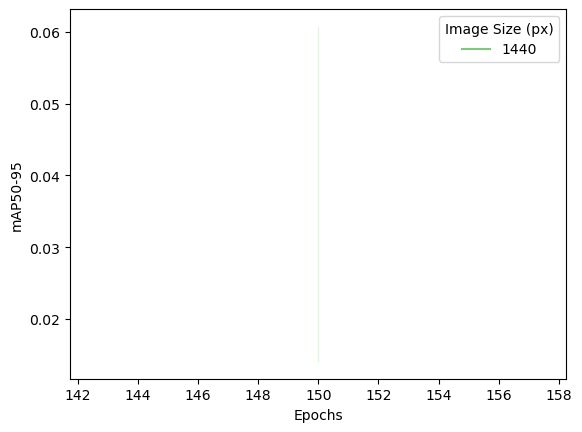

In [19]:
# iterate over cameras
mask_list = []
for tdataset in val_df['Train Dataset'].unique().tolist():
    mask_list.append(val_df['Train Dataset'] == tdataset) 
    
    # iterate over model
    for model in val_df[join_mask( mask_list )]['Model Name'].unique().tolist(): 
        mask_list.append((val_df['Model Name'] == model))

        current_df = val_df[ join_mask( mask_list ) ]
        #display(current_df)
        for metric in ['mAP50-95']: #plot_metrics:
            fig = plt.figure()
            axs = sns.lineplot(data=current_df, x='Epochs', y=metric, hue='Image Size (px)', palette='Accent' )
            axs.set_title(f"{metric} varying Image Size for {model} (camera {camera})") 
            axs.set_ylim([0,1])
            plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"validation_{metric}_{camera}_{model}_vary_image_size.png"))
            plt.close()
        mask_list.pop()
    mask_list.pop()

In [20]:
# iterate over cameras
mask_list = []
for camera in val_df['Camera'].unique().tolist():
    mask_list.append(val_df['Camera'] == camera) 
    dname=camera
    if camera[0].islower():
        dname=camera.capitalize()
    # iterate over model
    for imagesize in val_df[join_mask( mask_list )]['Image Size (px)'].unique().tolist(): 
        mask_list.append((val_df['Image Size (px)'] == imagesize))

        current_df = val_df[ join_mask( mask_list ) ]
        #display(current_df)
        for metric in ['mAP50-95']: #plot_metrics
            fig = plt.figure()
            axs = sns.lineplot(data=current_df, x='Epochs', y=metric, hue='Model Name', palette='Accent' )
            axs.set_title(f"{metric} Varying Model Size for {imagesize}px Image\nDataset {dname} ") 
            axs.set_ylim([0,1])
            plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"validation_{metric}_{camera}_{imagesize}px_vary_model.png"))
            #plt.show()
            plt.close()
        mask_list.pop()
    mask_list.pop()

yolov11m, 736


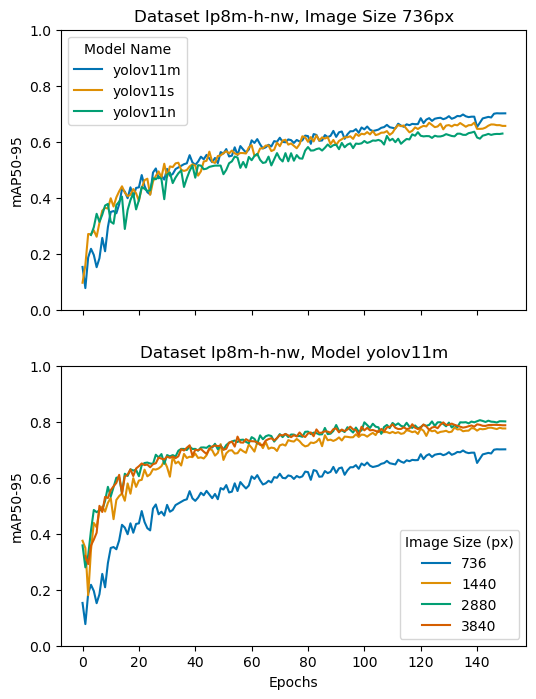

yolov11m, 1440


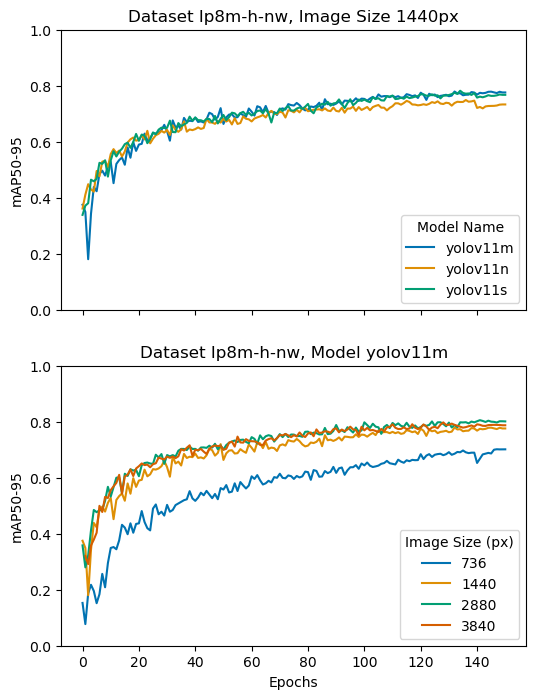

yolov11m, 2880


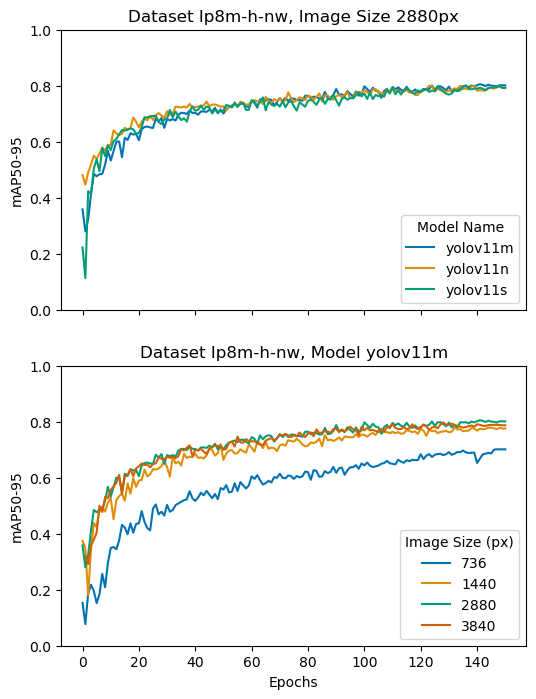

yolov11m, 3840


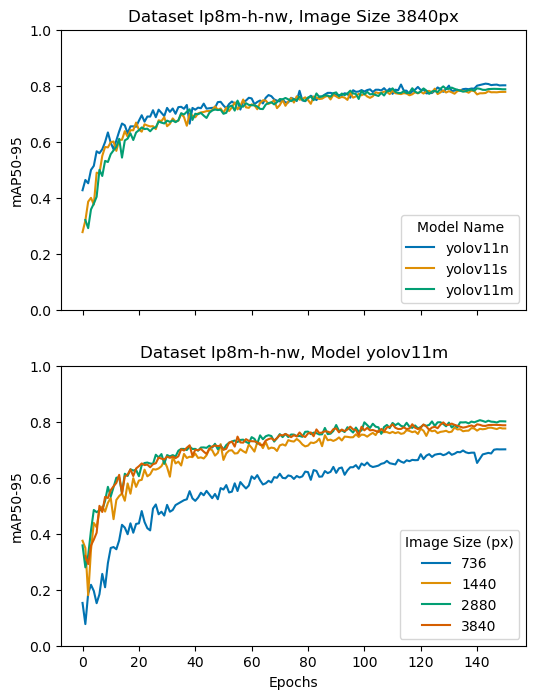

yolov11n, 1440


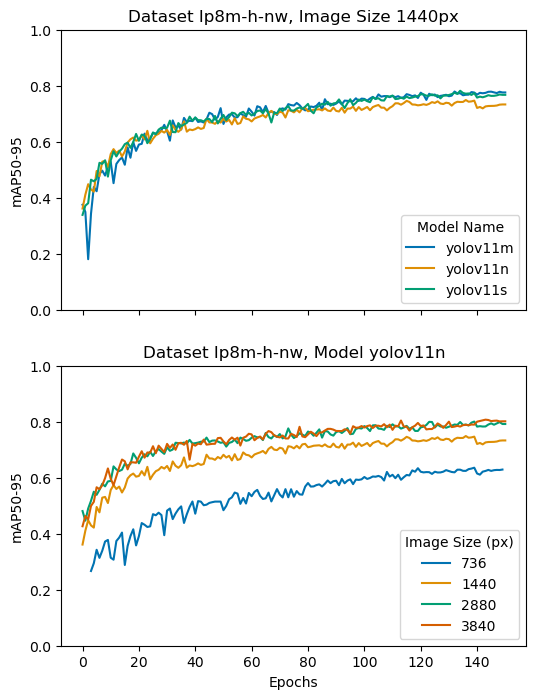

yolov11n, 2880


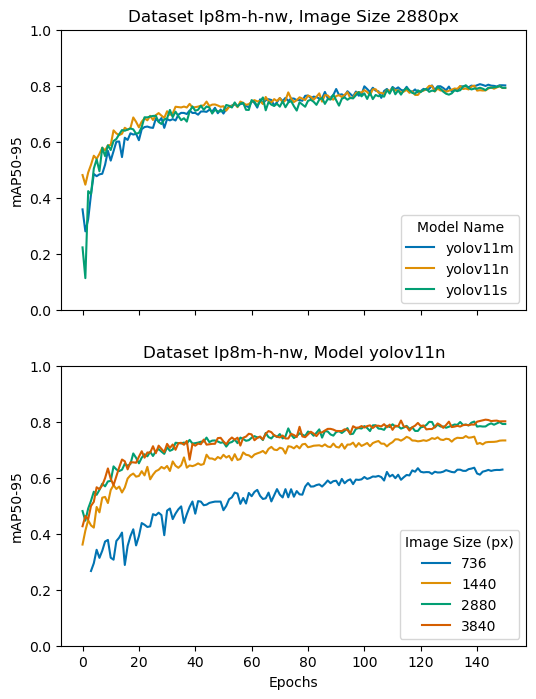

yolov11n, 3840


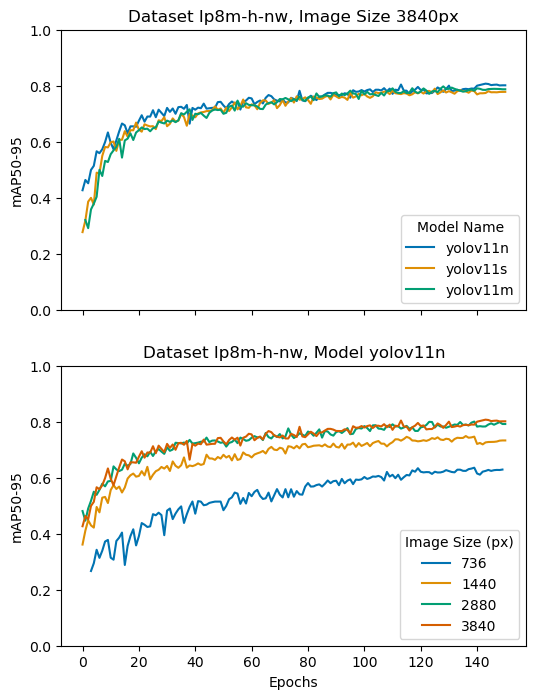

yolov11n, 736


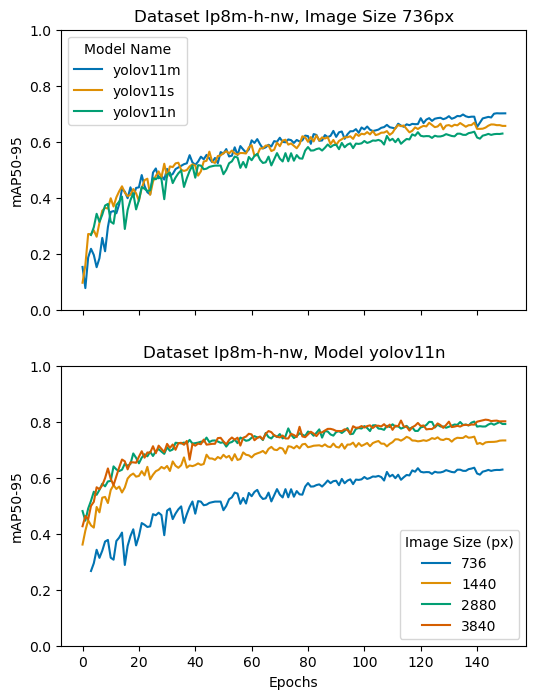

yolov11s, 736


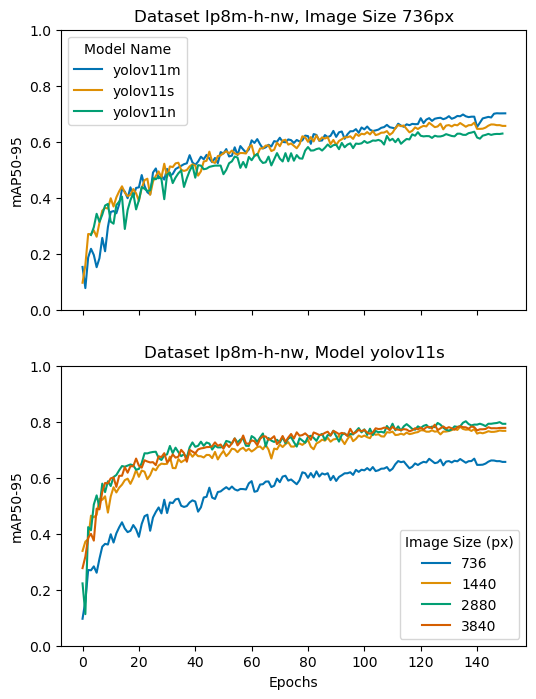

yolov11s, 1440


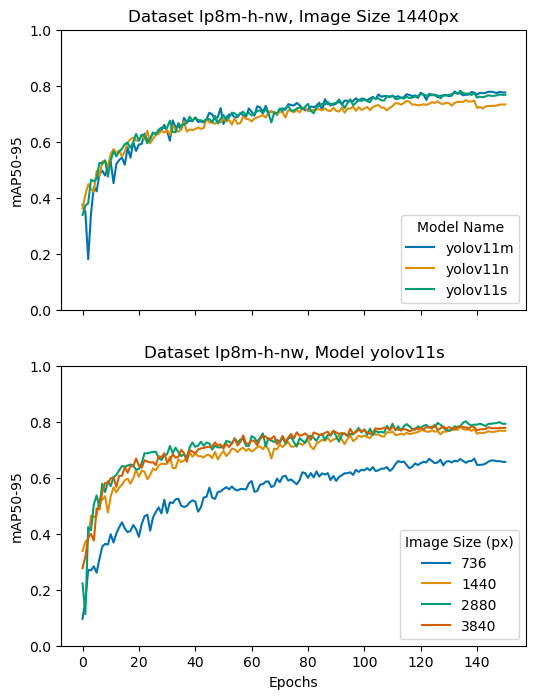

yolov11s, 2880


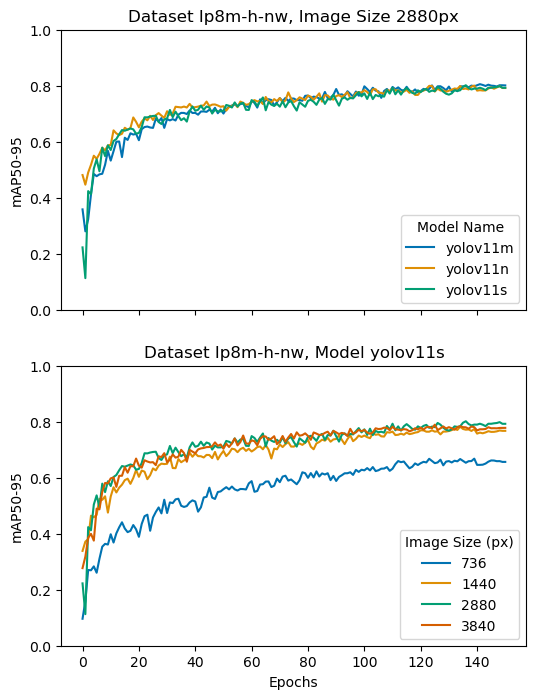

yolov11s, 3840


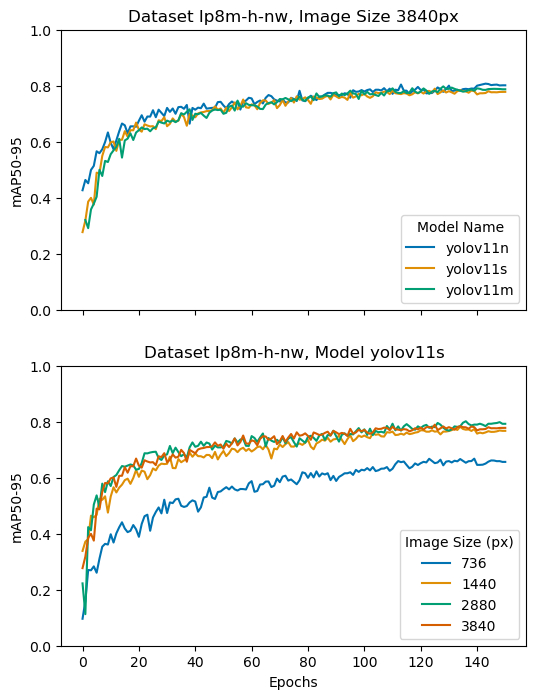

yolov11m, 1440


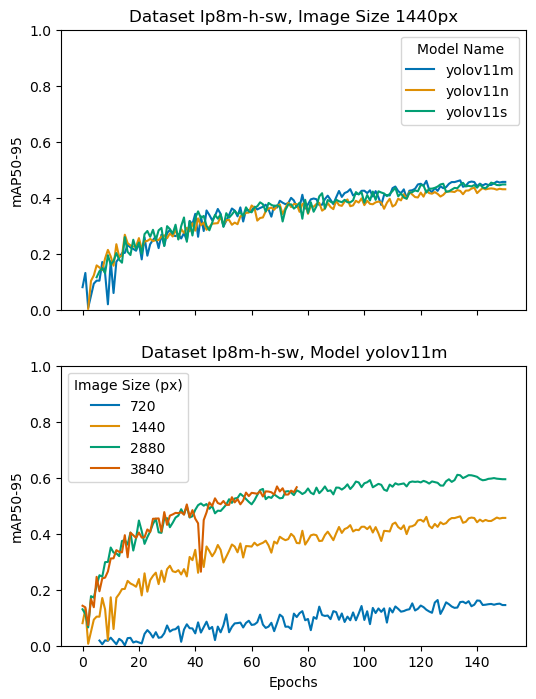

yolov11m, 2880


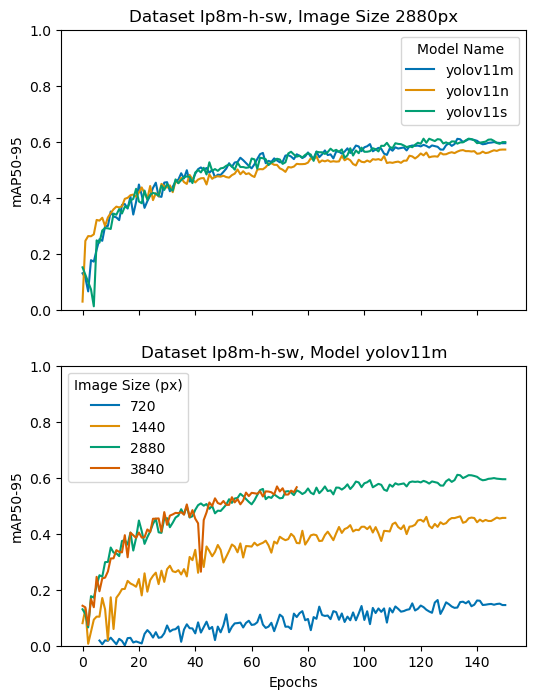

yolov11m, 3840


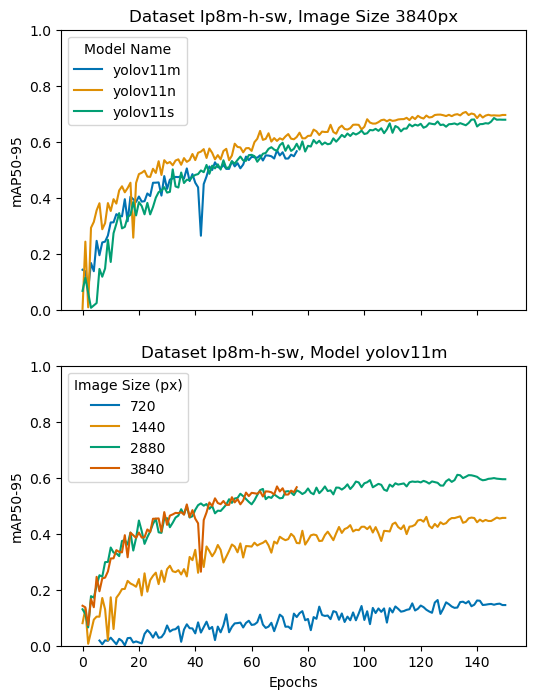

yolov11m, 720


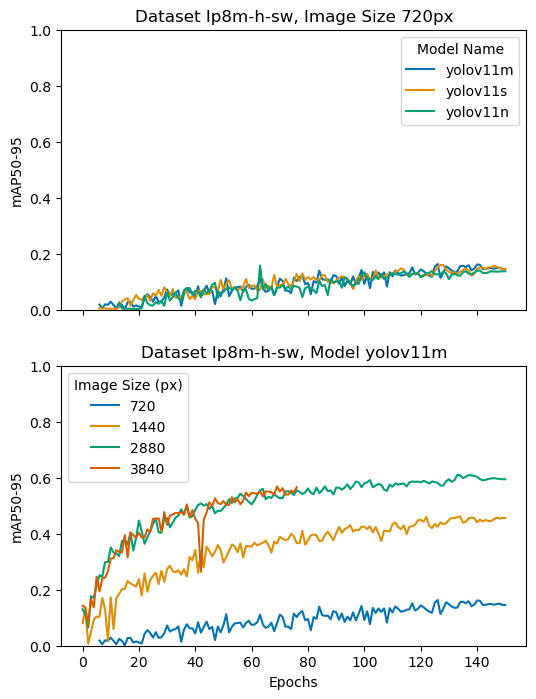

yolov11n, 2880


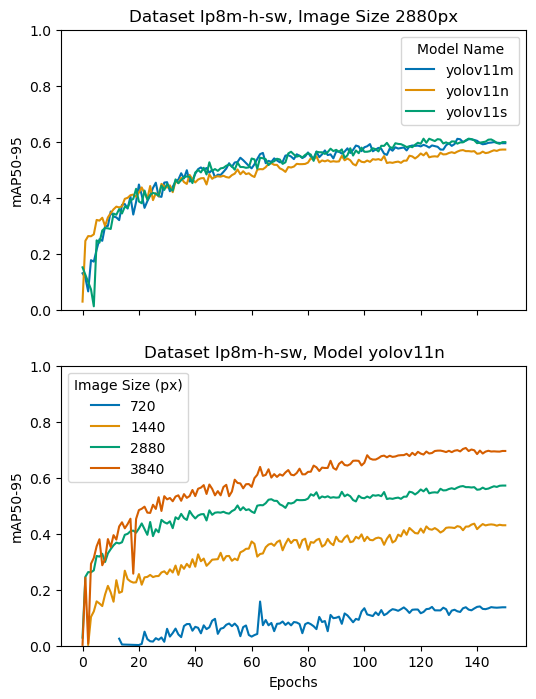

yolov11n, 3840


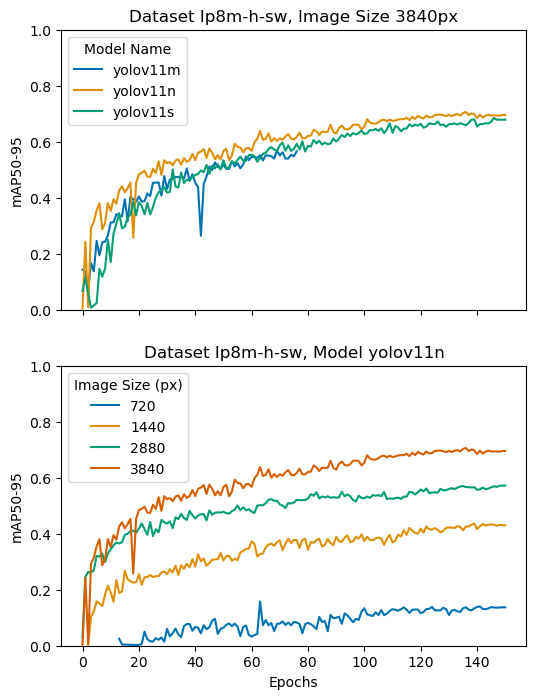

yolov11n, 1440


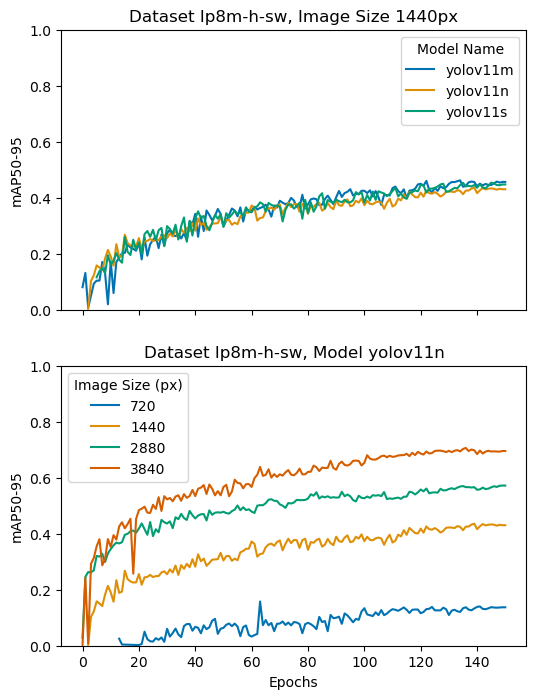

yolov11n, 720


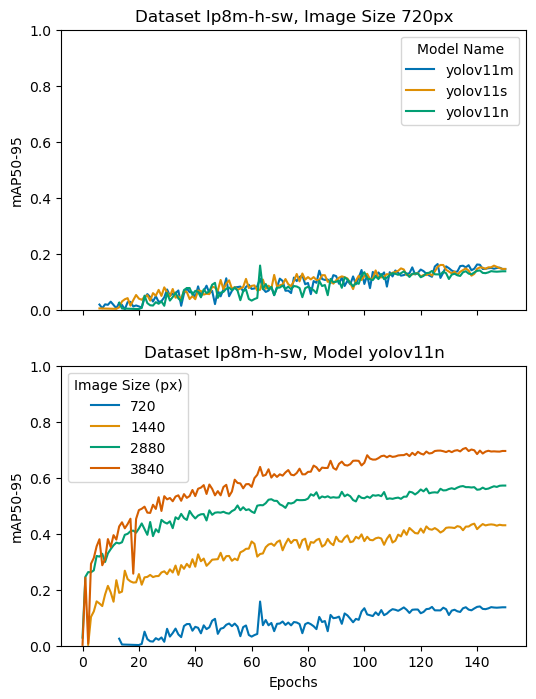

yolov11s, 2880


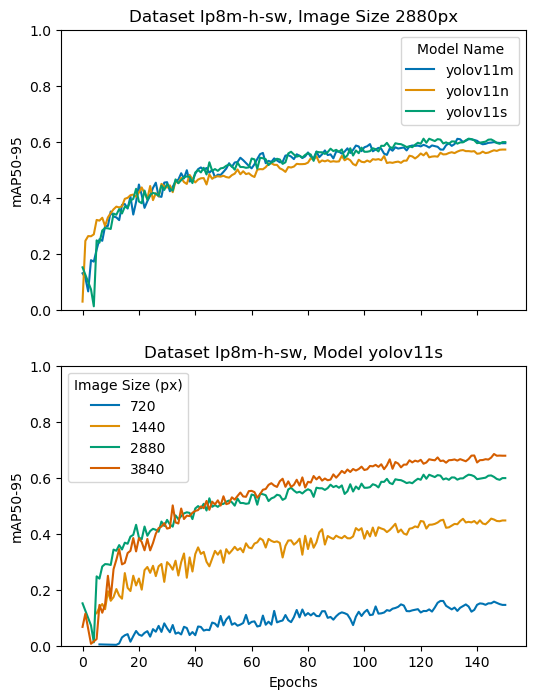

yolov11s, 3840


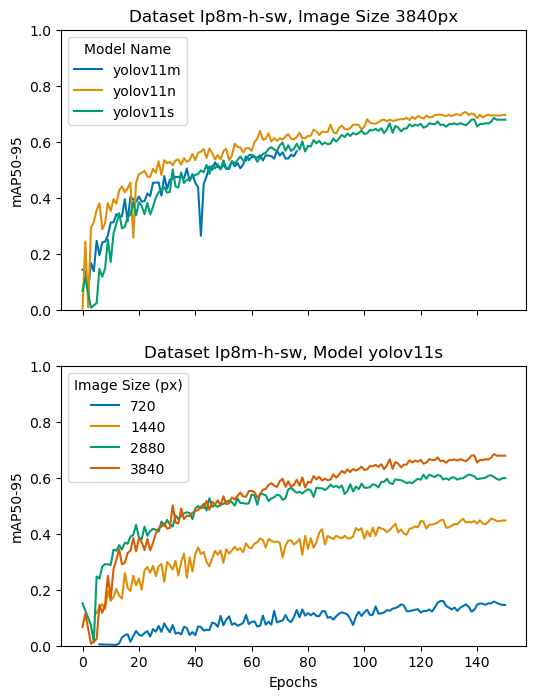

yolov11s, 1440


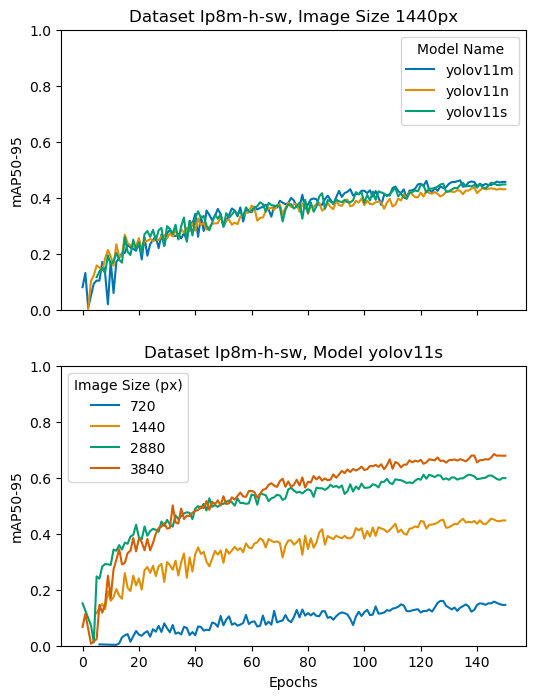

yolov11s, 720


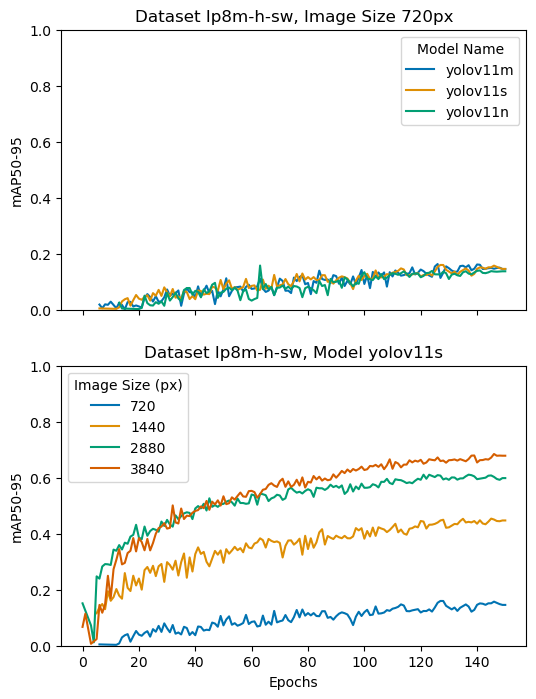

yolov11n, 2880


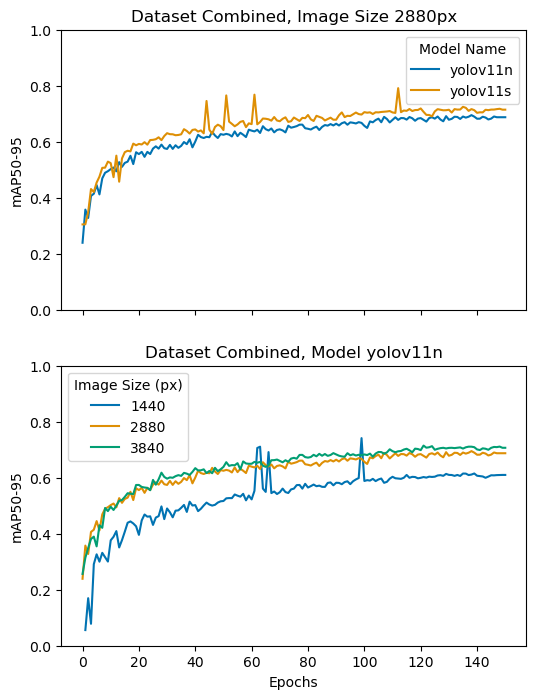

yolov11n, 3840


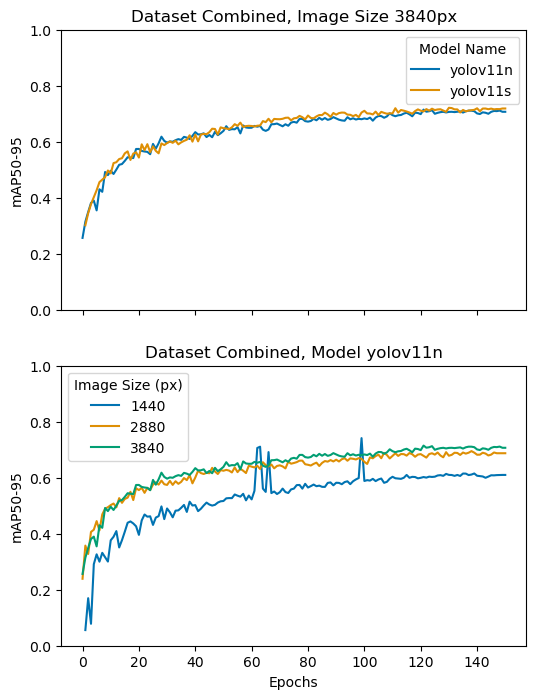

yolov11n, 1440


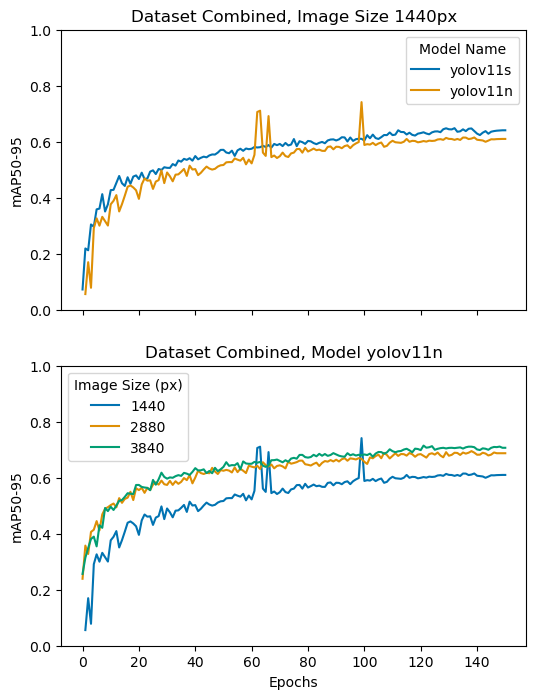

yolov11s, 1440


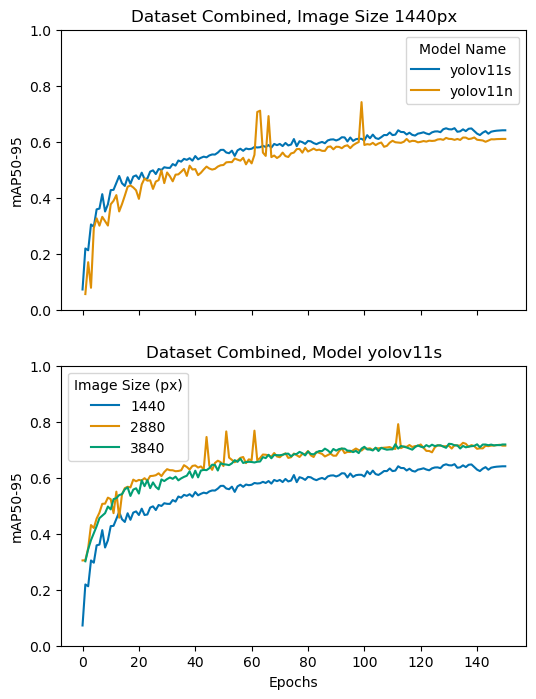

yolov11s, 2880


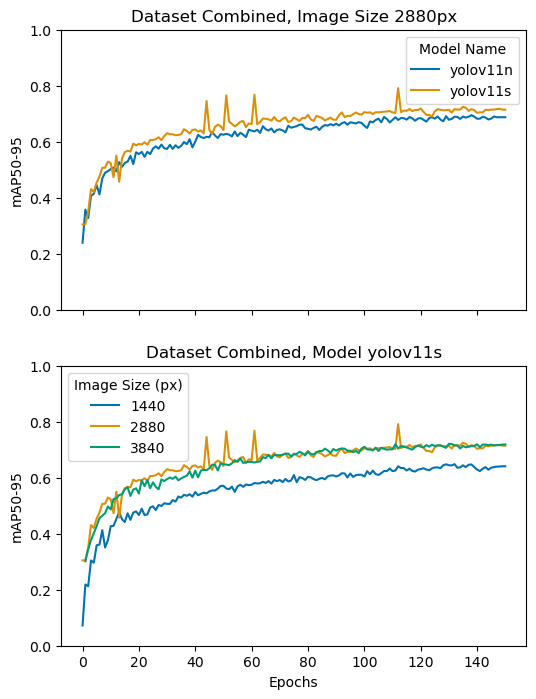

yolov11s, 3840


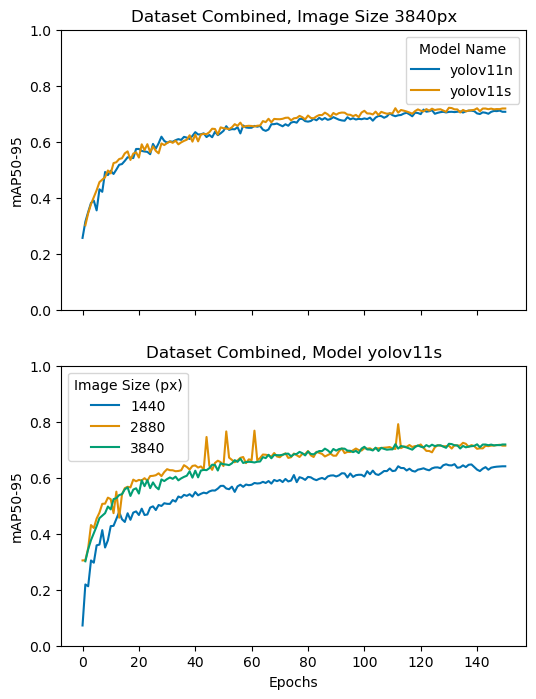

In [21]:
#params
pd.set_option('display.max_rows', 500)


metric="mAP50-95"
val_df.sort_values(['Epochs', 'Model Name', 'Image Size (px)'], inplace=True)


#display(vary_model_df)
#display(vary_image_df)
#display(model_img_df)
#fig, axs = plt.matplotlib.pyplot.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10,8))

#sp1 = sns.lineplot(data=vary_model_df, x='Epochs', y=metric, hue='Model Name', palette='Accent', ax=axs[0])
#axs[0].set_title(f"{metric} Varying Model Size for 3840px Images (camera {camera})") 

#sp2 = sns.lineplot(data=vary_image_df, x='Epochs', y=metric, hue='Image Size (px)', palette='Accent', ax=axs[1] )
#axs[1].set_title(f"{metric} Varying Image Size for model yolo11n (camera {camera})") 

#plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"validation_camera_model_{camera}_{imagesize}px_{metric}.png"))
#plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"validation_single_camera_model_{camera}_{metric}_vary_model_imgsize.png"))



#camera="IP8M-H-SW"
img_mask_list=[]
model_mask_list=[]
for camera in val_df['Camera'].unique().tolist():
    img_mask_list.append(val_df['Camera'] == camera) 
    model_mask_list.append(val_df['Camera'] == camera) 
    dname=camera
    if camera[0].islower():
        dname=camera.capitalize()
        
    # iterate over model
    for model in val_df[ join_mask( model_mask_list ) ]['Model Name'].unique().tolist(): 
        model_mask_list.append((val_df['Model Name'] == model))

        for imagesize in val_df[ join_mask( model_mask_list )]['Image Size (px)'].unique().tolist(): 
            print(f"{model}, {imagesize}")
            img_mask_list.append((val_df['Image Size (px)'] == imagesize))

            vary_model_df = val_df[ join_mask(img_mask_list)] 
            vary_image_df = val_df[ join_mask(model_mask_list) ]

            fig, axs = plt.matplotlib.pyplot.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(6,8))
            axs[0] = sns.lineplot(data=vary_model_df, x='Epochs', y=metric, hue='Model Name', palette='colorblind', ax=axs[0] )
            axs[0].set_title(f"Dataset {camera.capitalize()}, Image Size {imagesize}px")
            axs[0].set_ylim([0,1])
            
            axs[1] = sns.lineplot(data=vary_image_df, x='Epochs', y=metric, hue='Image Size (px)', palette='colorblind', ax=axs[1])
            axs[1].set_title(f"Dataset {camera.capitalize()}, Model {model}")
            axs[1].set_ylim([0,1])

            plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"validation_vary_image_model_{metric}_{camera}_{model}_{imagesize}.png"))

            plt.show()
            plt.close()
            img_mask_list.pop()
        model_mask_list.pop()
    img_mask_list.pop()
    model_mask_list.pop()
    
    

#camera="IP8M-H-NW"
#vary_model_df = val_df[(val_df['Camera']==camera) & (val_df['Image Size (px)'] == imagesize)] 
#vary_image_df = val_df[(val_df['Camera']==camera) & (val_df['Model Name'] == model)]

#fig, axs = plt.matplotlib.pyplot.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(6,8))
#axs[0] = sns.lineplot(data=vary_model_df, x='Epochs', y=metric, hue='Model Name', palette='colorblind', ax=axs[0] )
#axs[0].set_title(f"Varying Model Sizes, {imagesize}px Images\nDataset {camera}") 
#axs[0].set_ylim([0,1])


#axs[1] = sns.lineplot(data=vary_image_df, x='Epochs', y=metric, hue='Image Size (px)', palette='colorblind', ax=axs[1])
#axs[1].set_title(f"Varying Image Sizes, yolo11n\nDataset {camera}") 
#axs[1].set_ylim([0,1])
#plt.savefig(os.path.join("/data/mtmoore/school/CSiML_AI395T/final_project/plots", f"validation_vary_image_model_{camera}_{metric}.png"))


In [68]:
dnames = [ "test-set-1camera-ip8m-g-nw_coco", 
           "test-set-1camera-ip8m-g-sw_yolov8",  
           "test-set-1camera-ip8m-h-sw_coco",
           "test-set-4cameras-dayonly_coco",
           "test-set-4cameras-nightonly_yolov8",
           "test-set-1camera-ip8m-g-nw_yolov8",  
           "test-set-1camera-ip8m-h-nw_coco", 
           "test-set-1camera-ip8m-h-sw_yolov8",
           "test-set-4cameras-dayonly_yolov8",
           "test-set-4cameras_yolov8",
           "test-set-1camera-ip8m-g-sw_coco",
           "test-set-1camera-ip8m-h-nw_yolov8", 
           "test-set-4cameras_coco",
           "test-set-4cameras-nightonly_coco",
         ]
for d in dnames:
    n = rename_test_dataset(d)
    print(f"{d} -> {n}")

test-set-1camera-ip8m-g-nw_coco -> 1camera_IP8M-G-NW
test-set-1camera-ip8m-g-sw_yolov8 -> 1camera_IP8M-G-SW
test-set-1camera-ip8m-h-sw_coco -> 1camera_IP8M-H-SW
test-set-4cameras-dayonly_coco -> 4cameras_dayonly
test-set-4cameras-nightonly_yolov8 -> 4cameras_nightonly
test-set-1camera-ip8m-g-nw_yolov8 -> 1camera_IP8M-G-NW
test-set-1camera-ip8m-h-nw_coco -> 1camera_IP8M-H-NW
test-set-1camera-ip8m-h-sw_yolov8 -> 1camera_IP8M-H-SW
test-set-4cameras-dayonly_yolov8 -> 4cameras_dayonly
test-set-4cameras_yolov8 -> 4cameras_all
test-set-1camera-ip8m-g-sw_coco -> 1camera_IP8M-G-SW
test-set-1camera-ip8m-h-nw_yolov8 -> 1camera_IP8M-H-NW
test-set-4cameras_coco -> 4cameras_all
test-set-4cameras-nightonly_coco -> 4cameras_nightonly
